In [1]:
from src.loader import modelLoader
import cv2
import numpy as np

loader = modelLoader('3A_ref')
loader.cuda()
model = loader.model

In [2]:
from src.loader import sampler
s = sampler('bulkice')

# 總結
- 梯度對特徵提取效果不理想
- laplace對邊的提取極好
- laplace $k=5$ 有效將邊粗化 $k=3$ 有效將點提取

In [3]:
load = s[0]
last = []
img1 = load['image'][0]
lp3 = cv2.Laplacian(img1,cv2.CV_16S,ksize=3)
lp3 = cv2.convertScaleAbs(lp3)
lp5 = cv2.Laplacian(img1,cv2.CV_16S,ksize=5)
lp5 = cv2.convertScaleAbs(lp5)
see = np.concatenate((img1, lp3, lp5),axis=1)
see = cv2.resize(see, (1600,400))
last.append(see)
last = np.concatenate(last,axis=0)

# sampler
- s[n]: dict {'image': np.ndarray, 'info': dict, 'position': dict {"O":np.ndarray (n * 3), "H": np.ndarray (n * 3)} }
- 'info': dict {'scale', 'lattice', 'ele_num', 'ele_name', 'comment'}

In [4]:
img2 = cv2.resize(img1,(256,256))

layer[14] -> O-up
layer[17:20] -> H-up, limit = 0, nodenoise
O-up ~ 2 H-up and H-bond

In [5]:
from findpeaks import findpeaks
from src.tools import imgsPeak
fpimg = cv2.cvtColor(load['image'][17], cv2.COLOR_BGR2GRAY)
hupimg = 255 - fpimg
fp = findpeaks(method='topology', togray=True,limit = 15, interpolate=2)
lp5l = []
for i in range(17,20):
    a = cv2.Laplacian(load['image'][i],cv2.CV_16S,ksize=5)
    a = cv2.convertScaleAbs(a)
    lp5l.append(a)
r = imgsPeak(load['image'][17:], fp, inverse=True, cluster_threshold = 5, border=3)
# fp.plot()

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpe

In [6]:
import src.seelib.cv2eff as cve
mask = cve.order_circ_mask(20)
print(mask)

(array([], dtype=int64), array([], dtype=int64))


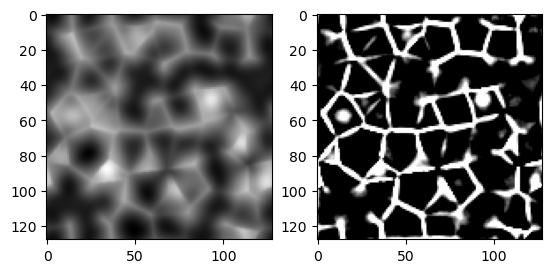

In [7]:
import matplotlib.pyplot as plt
import src.seelib.cv2eff as cve
p1 = plt.subplot(1, 2, 1)
pic = load['image'][0]
a = cv2.Laplacian(pic,cv2.CV_16S,ksize=5)
a[np.where(a > 0)] = 0
a = cv2.convertScaleAbs(a)
p1.imshow(pic)
p2 = plt.subplot(1, 2, 2)
p2.imshow(a)
plt.show()

In [8]:
from src.graph import Graph
import matplotlib.pyplot as plt
from src.tools import drawFindPeaksResult

g = Graph(load['info'])
g.addAtoms("O", load['position']['O'] @ load['info']['lattice'])
g.addAtoms("H", load['position']['H'] @ load['info']['lattice'])
onodes = g.get_nodes_by_attributes("elem", "O")
hnodes = g.get_nodes_by_attributes("elem", "H")
nodes = list(g.nodes())
g.link_nodes_by_dist(hnodes, onodes, radius = (0, 1.7), edgecolor=(256,256,256), edgethickness=4, edgeprior=2, tagFather=True)

g.link_nodes_by_dist(onodes, nodes, edgecolor=(192,192,192), edgeprior=0, edgethickness=2)


In [9]:
import src.seelib.npmath as npmath

def find_other(ia, dis_mat):
    i = hnodes.index(ia)
    pos = dis_mat[i]
    ibs = np.argsort(pos)
    posb = pos[ibs]
    for ib, pos in zip(ibs,posb):
        if pos < 1.6:
            continue
        if pos > 5:
            return
        ia_s = ia
        ib_f = ib
        ia_f = g.nodes[ia]['father']
        ia_os = g.nodes[ia_f]['son']
        if ia_os[0] == ia:
            ia_os = ia_os[1]
        else:
            ia_os = ia_os[0]
        ib_s = g.nodes[ib_f]['son']
        e = None
        # H-up and H-down not link
        
        delta =  g.nodes[ia_s]['position'] - g.nodes[ia_f]['position']
        arc = npmath.angle(delta, np.asarray([0,0,1]), mode="deg")
        print(arc)
        if arc > 150 or arc < 30:
            continue
        # Link H-O if newone is closer
        if (ia_f,ib_s[0]) in g.edges:
            e = g.edges[(ia_f,ib_s[0])]
            et = (ia_f,ib_s[0])
        elif (ia_f, ib_s[1]) in g.edges:
            e = g.edges[(ia_f,ib_s[1])]
            et = (ia_f,ib_s[1])
        if e is not None:
            if npmath.dist(e['u']['position'], e['v']['position']) > npmath.dist(g.nodes[ia]['position'], g.nodes[ib]['position']):
                g.remove_edge(*et)
                g.add_edge(ia, ib, color=(204,204,255), thickness=2, prior=0, u=g.nodes[ia], v=g.nodes[ib])
                find_other(et[1], dis_mat)
                return
        # Link H-O if other atoms is closer
        else:
            if (ia_os, ib_f) in g.edges:
                e = g.edges[(ia_os, ib_f)]
                et = (ia_os, ib_f)
                if npmath.dist(e['u']['position'], e['v']['position']) > npmath.dist(g.nodes[ia]['position'], g.nodes[ib]['position']):
                    g.remove_edge(*et)
                    g.add_edge(ia, ib, color=(204,204,255), thickness=2, prior=0, u=g.nodes[ia], v=g.nodes[ib])
                    find_other(ia_os, dis_mat)
                    return
            else:
                g.add_edge(ia, ib, color=(204,204,255), thickness=2, prior=0, u=g.nodes[ia], v=g.nodes[ib])
                return
                
pos_a = np.asarray(list(g.nodes[i]['position'] for i in hnodes))
pos_b = np.asarray(list(g.nodes[i]['position'] for i in onodes))
dis_mat = npmath.cdist(pos_a, pos_b)
for i, pos in enumerate(dis_mat):
    find_other(hnodes[i], dis_mat)
    

167.12726788713744
167.12726788713744
167.12726788713744
167.12726788713744
167.12726788713744
167.12726788713744
167.12726788713744
167.12726788713744
70.37485209312892
57.931922166448096
57.931922166448096
95.4075556709981
60.82493857069043
60.82493857069043
162.5951667335259
162.5951667335259
162.5951667335259
140.50483478134095
140.50483478134095
140.50483478134095
90.62851846582377
89.92218624617718
163.95756027804805
163.95756027804805
163.95756027804805
163.95756027804805
163.95756027804805
163.95756027804805
163.95756027804805
108.89579956113104
56.16148909428559
56.16148909428559
140.90799277994083
140.90799277994083
64.75900571402288
64.75900571402288
150.31327243106006
150.31327243106006
150.31327243106006
150.31327243106006
150.31327243106006
91.16129252336822
54.86790393338671
57.931922166448096
57.931922166448096
57.931922166448096
57.931922166448096
83.67827371712565
76.16419701832268
158.87050464369662
158.87050464369662
158.87050464369662
158.87050464369662
158.8705046

In [10]:
g.link_nodes_by_bounds(onodes,onodes)
g.link_nodes_by_bounds(onodes,hnodes)

True

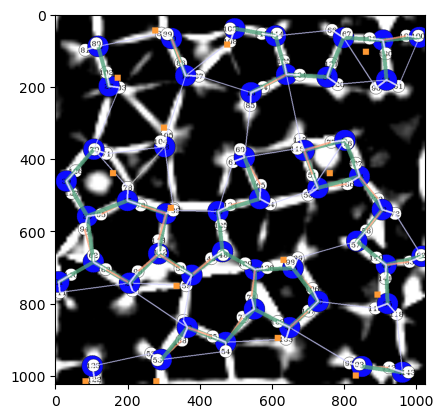

In [11]:
k = cv2.resize(a,(1024,1024))
k = g.plotNodes(k, resize=(1024,1024))
k = g.plotEdges(k, resize=(1024,1024), transparency=0.8)
# hup_pos = arrayReshape(r[...,:2], img1.shape[:2], np.diag(g.lattice)[:2])
k = drawFindPeaksResult(k, r)
imgplot = plt.imshow(k)
cv2.imwrite("test.png", k)

In [12]:
mask = np.zeros((10,10))
mask = cv2.circle(mask, (5,5), 4, 1, 1)
print(mask)
order = mask.nonzero()
pos_order = np.asarray(order).T
pos_order = pos_order - (5,5)


print(mask)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


from src.tools import cdist
ref_img = load['image'][1]
ref_img = cv2.resize(ref_img, (32,32))
pos = g.getAtomsPos()
o_pos = pos["O"]
h_pos = pos["H"]
dis_mat = cdist(o_pos, h_pos) < 4
dis_mat = np.triu(dis_mat).nonzero()


import src.seelib.npmath as npmath
a = np.zeros((10,10))
b = np.zeros((10,10))
b[2,2] = 1
b[4,4] = 1
a[np.where(b == 0)] = 1
print(a)
np.argmin(a, axis=0)